# Pré-Processamento

In [285]:
# Operações matemáticas e matriciais
import numpy as np
from sklearn.metrics import mean_squared_error

# Manipulação e análise dos conjunto de dados
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# LSTM
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# ARIMA
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from pmdarima import utils

import warnings
warnings.filterwarnings("ignore")

In [82]:
# pd.read_csv(): Carregando o DataSet. 
# index_col=: Configurando a feature 'data_internacao' como Index.
df = pd.read_csv('C:/Users/Mateus/Desktop/TCC/gerint_solicitacoes.csv', sep=';', 
                 index_col='data_internacao')

df.head()

,data_extracao,identificador_pessoa2,situacao,central_regulacao_origem,data_solicitacao,sexo,idade,municipio_residencia,solicitante,municipio_solicitante,codigo_cid,carater,tipo_internacao,tipo_leito,data_autorizacao,data_alta,executante,horas_na_fila
data_internacao,,,,,,,,,,,,,,,,,,
2018-05-03,2022-07-05,5d0bd349bb70e2ad30fd31d96c0093ff,COM_ALTA,REGULACAO HOSPITALAR,2018-04-24,FEMININO,59.0,BENTO GONCALVES,HOSPITAL NOSSA SENHORA DA CONCEICAO SA,PORTO ALEGRE,N872,ELETIVA,PRÓPRIA,ENFADULTO,2018-04-24,2018-05-03,HOSPITAL NOSSA SENHORA DA CONCEICAO SA,216
2018-05-03,2022-07-05,0d974460021c1e404dcc3b141be06448,COM_ALTA,REGULACAO HOSPITALAR,2018-05-03,MASCULINO,5.0,SAPIRANGA,HOSPITAL SAO LUCAS DA PUCRS,PORTO ALEGRE,L989,ELETIVA,PRÓPRIA,ENFPEDIATRICA,2018-05-03,2018-05-03,HOSPITAL SAO LUCAS DA PUCRS,0
2018-05-02,2022-07-05,8f0a4d1a34fcb3fda004a244f2fc6f27,COM_ALTA,REGULACAO HOSPITALAR,2018-05-02,MASCULINO,12.0,NOVO HAMBURGO,HOSPITAL NOSSA SENHORA DA CONCEICAO SA,PORTO ALEGRE,C910,ELETIVA,PRÓPRIA,ENFADULTO,2018-05-02,2018-06-20,HOSPITAL NOSSA SENHORA DA CONCEICAO SA,0
2018-05-02,2022-07-05,5e2b9c48abcdb226a1e8723402447ba7,COM_ALTA,REGULACAO HOSPITALAR,2018-05-02,FEMININO,62.0,PALMARES DO SUL,INSTITUTO DE CARDIOLOGIA,PORTO ALEGRE,I200,ELETIVA,PRÓPRIA,ENFADULTO,2018-05-02,2018-05-11,INSTITUTO DE CARDIOLOGIA,0
2018-05-03,2022-07-05,55fe0eefb0d5749f420c7c7c08ffa39c,COM_ALTA,REGULACAO HOSPITALAR,2018-05-03,MASCULINO,45.0,TAQUARUCU DO SUL,HOSPITAL SAO LUCAS DA PUCRS,PORTO ALEGRE,K603,ELETIVA,PRÓPRIA,ENFADULTO,2018-05-03,2018-05-03,HOSPITAL SAO LUCAS DA PUCRS,0


In [83]:
# .drop(): Removendo as colunas que não utilizaremos
df = df.drop(columns=['solicitante', 'situacao', 'data_solicitacao', 
                      'data_autorizacao', 'data_alta', 'horas_na_fila', 
                      'identificador_pessoa2', 'data_extracao', 
                      'central_regulacao_origem', 'municipio_residencia', 
                      'municipio_solicitante', 'tipo_internacao', 'sexo', 
                      'idade', 'codigo_cid', 'executante'])

# Visualizando o DataSet de Data da Internação
df.sort_index().head()

,carater,tipo_leito
data_internacao,,
0202-01-13 00:00:00,URGENCIA,ENFADULTO
1942-01-01,URGENCIA,ENFADULTO
1954-11-09,URGENCIA,ENFADULTO
1956-04-05,URGENCIA,ENFADULTO
1956-04-05,URGENCIA,ENFADULTO


In [365]:
df.sort_index().head(10)

,internacoes
data_internacao,
2018-01-02,1.0
2018-01-03,0.0
2018-01-04,0.0
2018-01-05,13.0
2018-01-06,0.0
2018-01-07,0.0
2018-01-08,26.0
2018-01-09,17.0
2018-01-10,5.0


In [85]:
# Verificando se temos dados faltantes
df.isnull().sum()

carater       0
tipo_leito    0
dtype: int64

In [86]:
# Convertendo as datas para o formato datetime
df.index = pd.to_datetime(df.index, errors='coerce', 
                          infer_datetime_format=True)

# Vamos selecionar somente os Registros após o Ano de 2018
df = df[df.index.year >= 2018]

# Selecionando apenas as internações 'UTIADULTO' e 'URGENCIA'.
df = df[(df['carater'] == 'URGENCIA') & (df['tipo_leito'] == 'UTIADULTO')]

# Agrupando as Internações por Data e somando o total por cada dia
df = pd.DataFrame(df.groupby(df.index)['tipo_leito'].count().rename('internacoes')) 

# Criando uma série com frequência diária
df = df.asfreq('D', fill_value=0.0) 

df.head()

,internacoes
data_internacao,
2018-01-02,1.0
2018-01-03,0.0
2018-01-04,0.0
2018-01-05,13.0
2018-01-06,0.0


In [87]:
# Total de registros após os filtros e agregações aplicadas
df.sum()

internacoes    51804.0
dtype: float64

### Análise Estatística

In [88]:
# Estatísticas Descritivas
df.describe()

,internacoes
count,1449.000000
mean,35.751553
std,38.992815
min,0.000000
25%,6.000000
50%,11.000000
75%,66.000000
max,197.000000


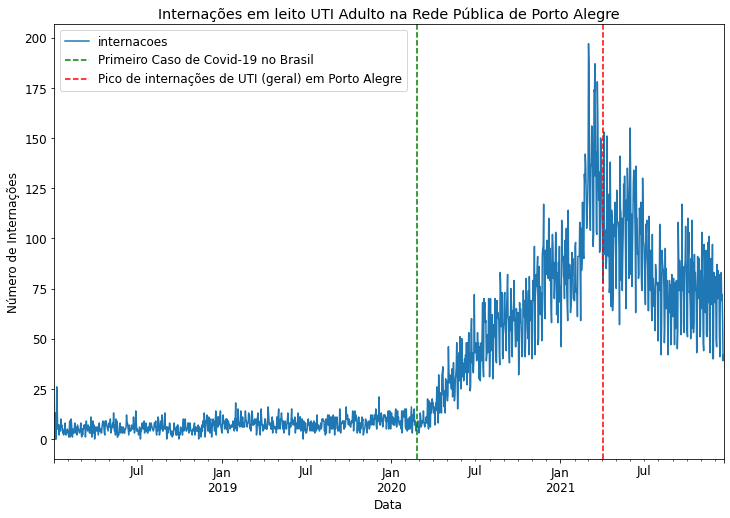

In [89]:
df.plot(title='Internações em leito UTI Adulto na Rede Pública de Porto Alegre', 
        xlabel="Data",
        ylabel="Número de Internações")
plt.axvline(x=['2020-02-26'], color="green", linestyle="dashed", label='Primeiro Caso de Covid-19 no Brasil')
plt.axvline(x=['2021-04-03'], color="red", linestyle="dashed", label='Pico de internações de UTI (geral) em Porto Alegre')

plt.legend()
plt.show()

# Implementação do Modelo LSTM

### Dados para Séries (transformação somente para LSTM)

Nesta etapa, a partir da variável de interesse, um novo conjunto será criado, onde cada coluna representará um atributo correspondente a em determinado tempo passado (lag) da variável de interesse. Desta forma, cada linha representará uma amostra e corresponderá a um novo exemplo composto pelos atributos 'X' criados e variável de interesse e 'y'.

In [93]:
# Função para criar as Janelas (Lags)
def create_series(data, window_size=1):
    data_as_np = data.to_numpy()
    X, y = [], []
    
    for i in range(len(data) - window_size):    
        # Criando as linhas de cada janela 
        row = [[a] for a in data_as_np[i:i+window_size]]
        X.append(row)
        
        # Criando os targets de cada janela
        target = data_as_np[i+window_size]
        y.append(target)
        
    return np.array(X), np.array(y)

In [94]:
# Definindo o tamanho do Lag
WINDOW_SIZE = 10

# Criando as janelas da Série Temporal
X, y = create_series(df['internacoes'], WINDOW_SIZE)

# Visualizando o formato dos dados gerados 
# já no formato adequado para as Redes Neurais: 3D-Array),
# onde X(n_amostras, window_size, n_features)
X.shape, y.shape

((1439, 10, 1), (1439,))

In [95]:
# Visualizando as variáveis (janelas) que foram criadas, de acordo com o tamanho pré-definido na etapa anterior.
# Desta forma, cada atributo representa um determinado atraso (lag) no tempo em relação a variável alvo 'y'. 
pd.concat(
    [pd.DataFrame(X[:,:,0],index=df.index[WINDOW_SIZE:], columns=['y(t-'+str(x)+')' for x in range(WINDOW_SIZE,0,-1)]), 
     pd.DataFrame(y, index=df.index[WINDOW_SIZE:], columns=['y(t)'])], 
    axis=1)

,y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t)
data_internacao,,,,,,,,,,,
2018-01-12,1.0,0.0,0.0,13.0,0.0,0.0,26.0,17.0,5.0,5.0,7.0
2018-01-13,0.0,0.0,13.0,0.0,0.0,26.0,17.0,5.0,5.0,7.0,2.0
2018-01-14,0.0,13.0,0.0,0.0,26.0,17.0,5.0,5.0,7.0,2.0,5.0
2018-01-15,13.0,0.0,0.0,26.0,17.0,5.0,5.0,7.0,2.0,5.0,7.0
2018-01-16,0.0,0.0,26.0,17.0,5.0,5.0,7.0,2.0,5.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-16,87.0,70.0,84.0,73.0,82.0,52.0,41.0,73.0,76.0,83.0,69.0
2021-12-17,70.0,84.0,73.0,82.0,52.0,41.0,73.0,76.0,83.0,69.0,72.0
2021-12-18,84.0,73.0,82.0,52.0,41.0,73.0,76.0,83.0,69.0,72.0,58.0


### Divisão dos Conjuntos em Treino, Validação e Teste

In [97]:
# Dividindo o conjunto em Treino e Teste (Train/Test Split)

# Definindo o tamanho do conjunto de treinamento
TRAIN_SIZE = int(len(X) * .9)

# Importando o módulo train_test_split do SkLearn
from sklearn.model_selection import train_test_split

# Dividindo os Conjuntos em Treino e Teste
# Importante: Como estamos trabalhando com Séries Temporais, devemos ajustar o parâmetro shuffle=False,
# pois queremos que os dados seja divididos em ordem cronológica e não embaralhados. Desta forma,
# os últimos registros serão selecionados para o conjunto de Teste.
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, shuffle=False)

# Imprimindo o formato dos conjuntos gerados
print(f'X_train_full{X_train_full.shape}, y_train_full{y_train_full.shape}')
print(f'X_test{X_test.shape}, y_test{y_test.shape}')

X_train_full(1295, 10, 1), y_train_full(1295,)
X_test(144, 10, 1), y_test(144,)


In [98]:
# Dividindo o conjunto de Treino em Train/Valid 

# Definindo o tamanho do conjunto de Validação
VALID_SIZE = int(len(X) * .8)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=VALID_SIZE, shuffle=False)

# Imprimindo o formato dos conjuntos gerados
print(f'X_train{X_train.shape}, y_train{y_train.shape}')
print(f'X_valid{X_valid.shape}, y_valid{y_valid.shape}')

X_train(1151, 10, 1), y_train(1151,)
X_valid(144, 10, 1), y_valid(144,)


In [99]:
# Proporção dos Conjuntos gerados
print(f'Treino: {round(len(y_train) / len(y) * 100, 2)}%')
print(f'Validação: {round(len(y_valid) / len(y) * 100, 2)}%')
print(f'Teste: {round(len(y_test) / len(y) * 100, 2)}%')

Treino: 79.99%
Validação: 10.01%
Teste: 10.01%


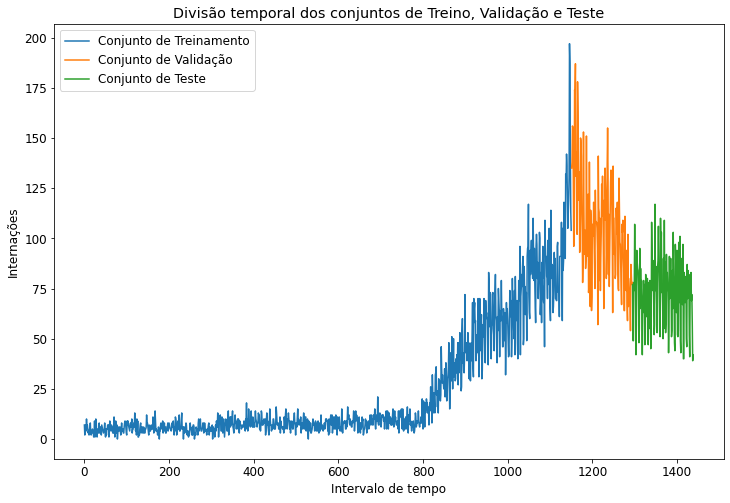

In [371]:
# Visualizando as divisões dos Conjuntos 
plt.plot(np.arange(0, y_train.shape[0]), y_train, 
         label='Conjunto de Treinamento')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid,
         label='Conjunto de Validação')
plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0], y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]), y_test,
         label='Conjunto de Teste')
plt.title('Divisão temporal dos conjuntos de Treino, Validação e Teste')
plt.xlabel('Intervalo de tempo')
plt.ylabel('Internações')
plt.legend()
plt.show()

### Instanciando o modelo LSTM

In [102]:
# Arquitetura do Modelo LSTM

lstm_model = Sequential()
lstm_model.add(InputLayer((WINDOW_SIZE, 1))) 
lstm_model.add(LSTM(150, activation='tanh'))
lstm_model.add(Dense(1, activation='linear'))
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 150)               91200     
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


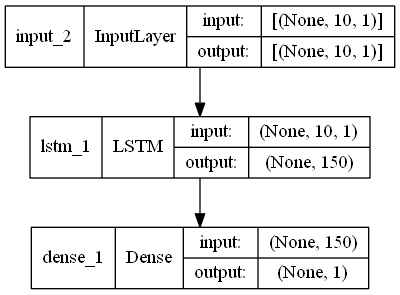

In [377]:
keras.utils.plot_model(lstm_model, show_shapes=True)

### Configurando e Treinando o modelo LSTM

In [103]:
# Criando uma checagem para salvar o melhor modelo gerado, 
# baseado na Loss function do conjunto de Validação 
# check_point = ModelCheckpoint(filepath='lstm_model/', monitor='val_loss', save_best_only=True)

# Criando uma checagem para interromper o Treinamento,
# caso a métrica definida não melhore em 'n' Épocas seguidas
early_stopping = EarlyStopping(monitor='val_loss', patience = 30)

# Configurando os Parâmetros do Modelo
lstm_model.compile(
    loss='mse', # Função de Custo
    optimizer=Adam(learning_rate=0.001), # Otimizador e taxa de aprendizado
    metrics=[RootMeanSquaredError()]) # Métrica usada para avaliação do modelo

# Treinando o Modelo
lstm_history = lstm_model.fit(X_train, y_train,
                         validation_data=(X_valid, y_valid),
                         epochs=200,
                         callbacks=[early_stopping], 
                         verbose=0)

In [105]:
# Salvando e Carregando o Modelo
# model1.save('lstm_model.h5')
# from keras.models import load_model
# new_model = load_model('lstm_model.h5')

### Avaliando o Modelo LSTM

In [241]:
# Avaliação do modelo LSTM no Conjunto de Teste 
print('RMSE (Conjunto Teste):', lstm_model.evaluate(X_test, y_test, verbose=0)[1])
print('Desvio padrão (Conjunto Teste):', y_test.std()) 

RMSE (Conjunto Teste): 15.014750480651855
Desvio padrão (Conjunto Teste): 17.83531136269622


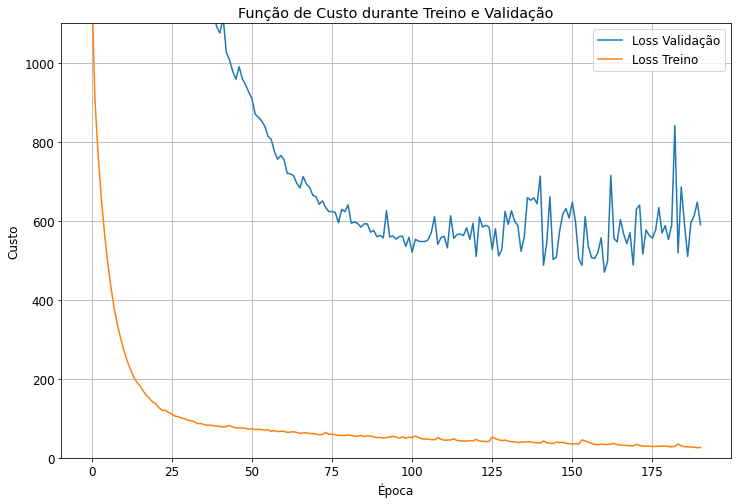

In [417]:
# Função de custo
plt.plot(lstm_history.history['val_loss'], label='Loss Validação')
plt.plot(lstm_history.history['loss'], label='Loss Treino')
plt.title('Função de Custo durante Treino e Validação')
plt.xlabel('Época')
plt.ylabel('Custo')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0,1100)
plt.show()

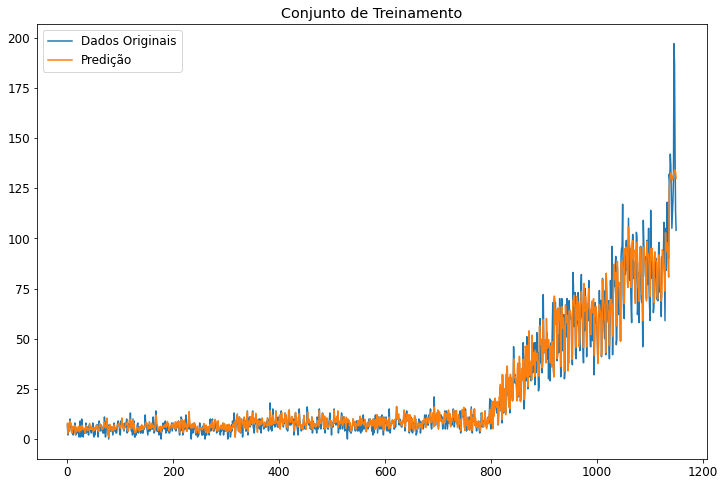

In [108]:
# Resultados no Conjunto de Treinamento

# Criando as predições no conjunto de Treinamento
train_pred = lstm_model.predict(X_train).flatten()

# Visualizando os registros e as predições
plt.plot(y_train[:], label='Dados Originais')
plt.plot(train_pred[:], label='Predição')
plt.title('Conjunto de Treinamento')
plt.legend()
plt.show();

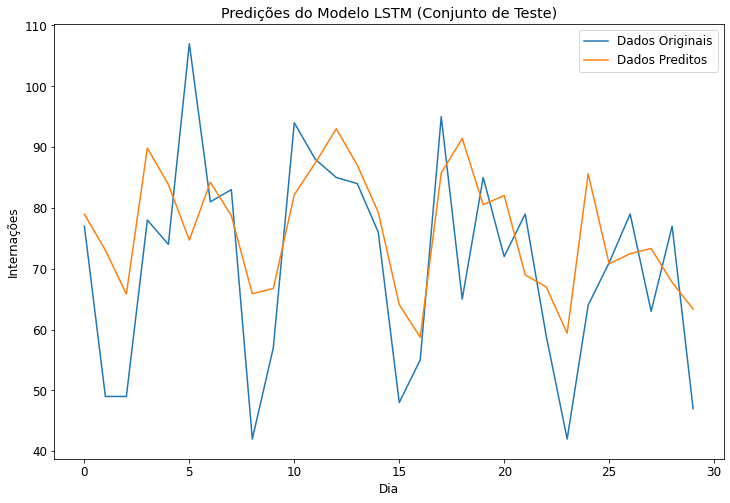

In [402]:
# Criando as predições no conjunto de Teste
lstm_test_pred = lstm_model.predict(X_test).flatten()

# Visualizando os 30 primeiros registros e as predições
plt.plot(y_test[:30], label='Dados Originais')
plt.plot(lstm_test_pred[:30], label='Dados Preditos')
plt.xlabel('Dia')
plt.ylabel('Internações')
plt.title('Predições do Modelo LSTM (Conjunto de Teste)')
plt.legend()
plt.show();

# Implementação do Modelo ARIMA

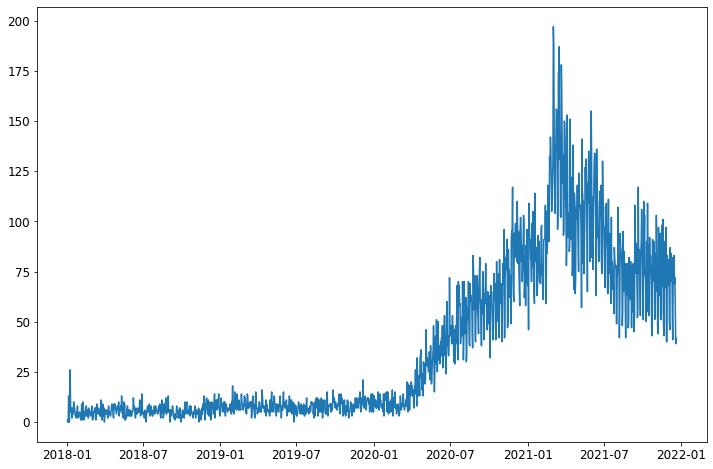

In [332]:
# Plotando o conjunto de Dados
plt.plot(df);

### Teste de Estacionariedade

In [335]:
# Verificando se a Série é Estacionária.
adfuller_test = adfuller(df)
print(f'p-value: ', adfuller_test[1])

p-value:  0.6631577826849179


In [336]:
# Diferenciação: transformando a Série em Estacionária
df_diff = df.diff().dropna()
# Exibição dos resultados
df_diff.head()

,internacoes
data_internacao,
2018-01-03,-1.0
2018-01-04,0.0
2018-01-05,13.0
2018-01-06,-13.0
2018-01-07,0.0


In [339]:
# Verificando se a Série é Estacionária.
adfuller_test = adfuller(df_diff)
print(f'p-value: ', round(adfuller_test[1], 10))

p-value:  3.76e-08


### Decomposição Sazonal

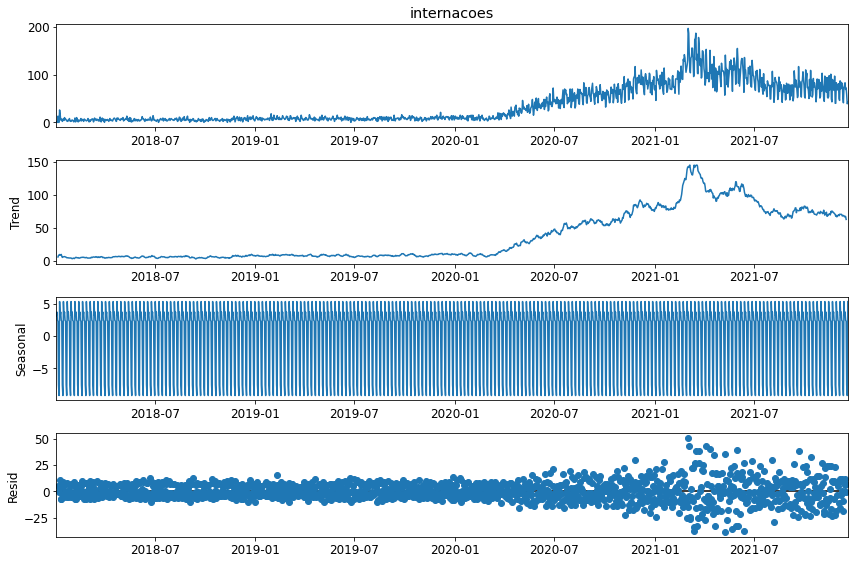

In [379]:
df_decompose = seasonal_decompose(df['internacoes'], )
df_decompose.plot();

Para conferir o período de Sazonalidade dos dados, podemos plotar o componente Sazonal de forma ampliada.

Neste caso, o **período é = 7.**

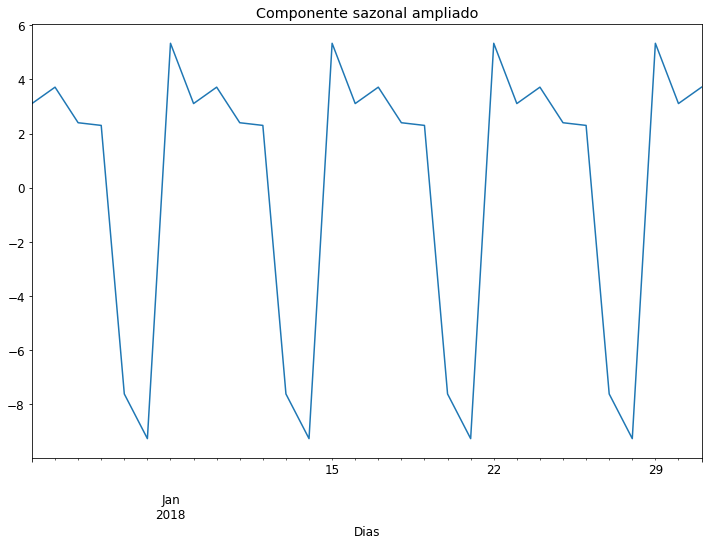

In [389]:
df_decompose.seasonal[:30].plot(title='Componente sazonal ampliado');
plt.xlabel('Dias');

**Gráfico ACF**: Também pode-se descobrir a sazonalidade utilizando a o Gráfico ACF.

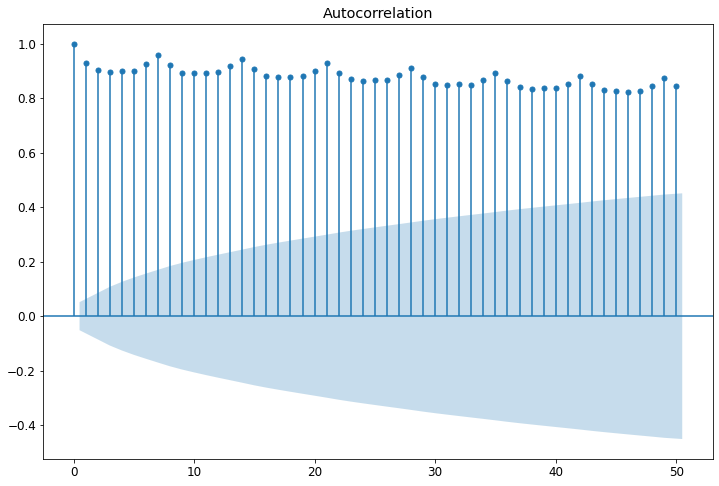

In [390]:
plot_acf(df, lags=50);

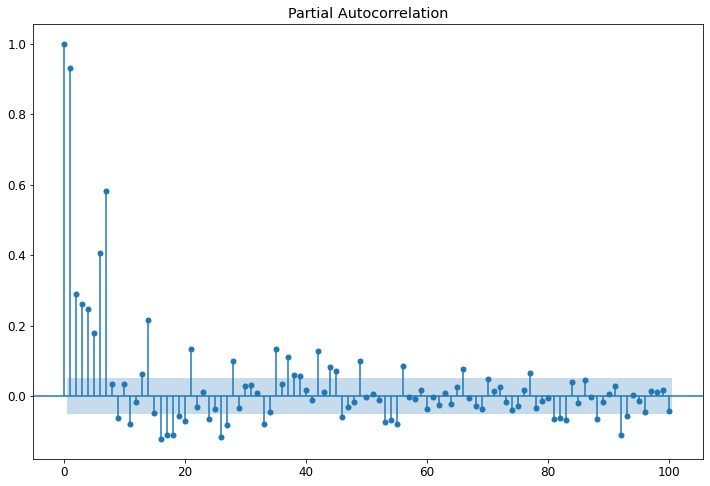

In [213]:
plot_pacf(df, lags=100);

### Módulo auto_arima

In [214]:
# Módulo 'auto_arima' para encontrar os ordens de (p,d,q)
auto_arima(df,        # série
           start_p=0, # menor valor de p 
           start_q=0, # menor valor de q
           max_p=5,   # maior valor de p
           max_q=5    # maior valor de q
          ).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11888.021, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11741.214, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11326.294, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11886.026, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11287.717, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11246.646, Time=0.77 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11629.516, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11203.304, Time=0.80 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11536.109, Time=0.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11151.473, Time=0.98 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=11489.127, Time=0.53 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=10940.818, Time=1.48 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=11233.881, Time=0.77 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=10740.331, Time=3.67 sec
 ARIMA(4,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1449
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -5244.627
Date:                Tue, 06 Sep 2022   AIC                          10513.253
Time:                        19:35:04   BIC                          10576.589
Sample:                             0   HQIC                         10536.890
                               - 1449                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1161      0.095      1.227      0.220      -0.069       0.302
ar.L1          0.6514      0.027     23.853      0.000       0.598       0.705
ar.L2         -1.3019      0.023    -56.495      0.000      -1.347      -1.257
ar.L3          0.5616      0.039     14.491      0.000       0.486       0.638
ar.L4         -0.8545      0.021    -40.779      0.000      -0.896      -0.813
ar.L5         -0.1499      0.025     -5.913      0.000      -0.200      -0.100
ma.L1         -1.5763      0.022    -72.079      0.000      -1.619      -1.533
ma.L2          1.9148      0.035     55.074      0.000       1.847       1.983
ma.L3         -1.7100      0.042    -40.795      0.000      -1.792      -1.628
ma.L4          1.4214      0.030     46.711      0.000       1.362       1.481
ma.L5         -0.6642      0.017    -37.967      0.000      -0.698      -0.630
sigma2        78.2117      1.467     53.311      0.000      75.336      81.087
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):              2622.96
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):              21.59   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Divisão dos Conjuntos em Treino e Teste

In [136]:
# Criando os conjunto de Treino e Teste
X = df.values
size = y_test.shape[0] # Para manter o mesmo conjunto de Teste 

train, test = X[:-size], X[-size:]
train.shape, test.shape

((1305, 1), (144, 1))

### Configurando e Treinando o Modelo ARIMA

In [227]:
# Modelo
arima_model = ARIMA(train, order=(5,1,5)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1305
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -4634.981
Date:                Tue, 06 Sep 2022   AIC                           9291.962
Time:                        19:37:48   BIC                           9348.868
Sample:                             0   HQIC                          9313.310
                               - 1305                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7174      0.029     24.880      0.000       0.661       0.774
ar.L2         -1.3605      0.023    -57.996      0.000      -1.407      -1.315
ar.L3          0.6619      0.040     16.481      0.000       0.583       0.741
ar.L4         -0.9125      0.021    -42.834      0.000      -0.954      -0.871
ar.L5         -0.0828      0.027     -3.090      0.002      -0.135      -0.030
ma.L1         -1.5785      0.023    -67.778      0.000      -1.624      -1.533
ma.L2          1.9420      0.034     56.532      0.000       1.875       2.009
ma.L3         -1.7371      0.041    -42.322      0.000      -1.818      -1.657
ma.L4          1.4318      0.030     48.204      0.000       1.374       1.490
ma.L5         -0.6491      0.018    -35.824      0.000      -0.685      -0.614
sigma2        69.0902      1.291     53.533      0.000      66.561      71.620
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):              3447.62
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):              20.68   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Avaliação dos Resultados

In [228]:
# Previsões no conjunto de Teste
# 'typ': é o tipo de predição. Como foi feito uma modificação nos dados no passo de Diferenciação, 
# deve-se configurar como 'levels' para retornar a predição na variável original, e não na transformada.

arima_pred = arima_model.predict(start=len(train), 
                                 end=len(train)+len(test)-1, dynamic=False, typ='levels')

13.493234549487006

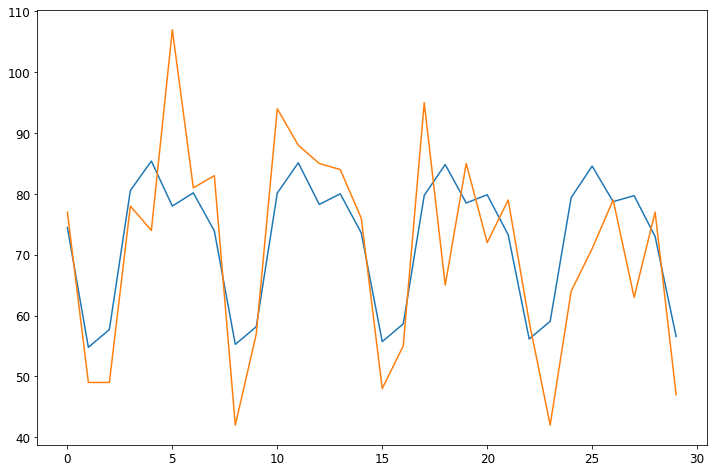

In [355]:
plt.plot(arima_pred[:30])
plt.plot(test[:30])

np.sqrt(mean_squared_error(test, arima_pred))

### Análise dos Residuais do Modelo ARIMA

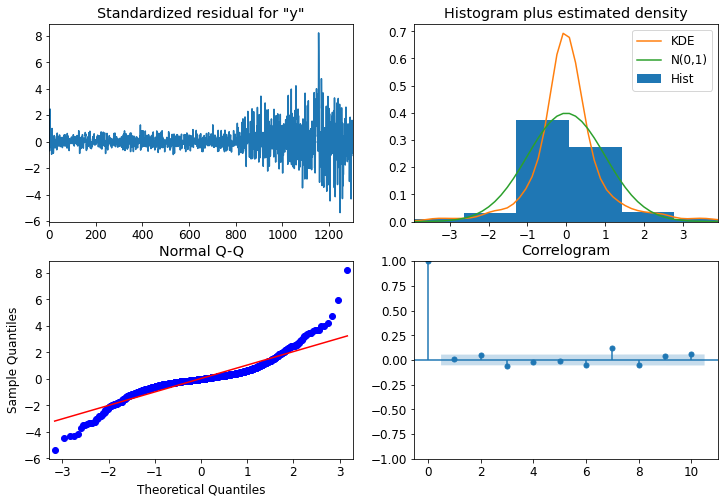

In [392]:
# Verificando os Residuais
arima_model.plot_diagnostics();

# Visualizando os Dados Observados e as Previsões dos Modelos LSTM e ARIMA

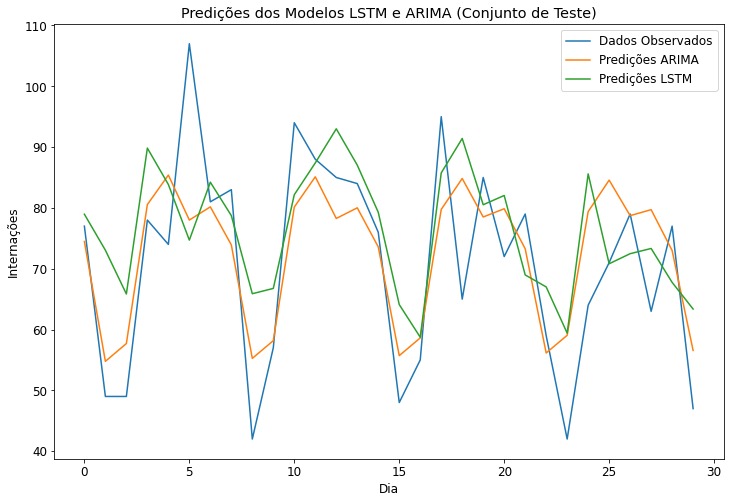

In [437]:
plt.plot(test[:30], label='Dados Observados')
plt.plot(arima_pred[:30], label='Predições ARIMA')
plt.plot(lstm_test_pred[:30], label='Predições LSTM')
plt.xlabel('Dia')
plt.ylabel('Internações')
plt.title('Predições dos Modelos LSTM e ARIMA (Conjunto de Teste)')
plt.legend()
plt.show();

In [415]:
# RMSE dos Modelos LSTM e ARIMA

print(f'RMSE do Modelo LSTM (Conjunto Teste): {round(np.sqrt(mean_squared_error(y_test, lstm_test_pred)),2)}')
print(f'RMSE do Modelo ARIMA (Conjunto Teste): {round(np.sqrt(mean_squared_error(test, arima_pred)),2)}')

RMSE do Modelo LSTM (Conjunto Teste): 15.01
RMSE do Modelo ARIMA (Conjunto Teste): 13.49
